# Preliminary Analysis of Statement Sentiment by Lexicon
Analyse statement by Loughran and McDonald word list to see if the relationship between economy and net sentiment 

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime as dt
import os
import pickle
import codecs
import re
from tqdm import tqdm_notebook as tqdm

#For tokenizing sentences
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\miche\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [49]:
plt.style.use('seaborn-whitegrid')

### Reading the data in

In [50]:
file = open("../data/FOMC/statement.pickle", "rb")
Data = pd.read_pickle(file)

In [51]:
Data['text'] = Data['contents'].apply(lambda x: x.replace('\n\n[SECTION]\n\n', '').replace('\n', ' ').replace('\r', ' ').strip())
Data.drop(columns=['title'], axis=1, inplace=True)

In [52]:
print('Date: ', Data.iloc[-1]['date'].strftime('%Y-%m-%d'))
print('Speaker: ', Data.iloc[-1]['speaker'])
print('Text: \n\n', Data.iloc[-1]['contents'].replace('\n[SECTION]\n', '')[1192:])

Date:  2021-07-28
Speaker:  Jerome Powell
Text: 

 Federal Reserve is committed to using its full range of tools to support the U.S. economy in this challenging time, thereby promoting its maximum employment and price stability goals.

With progress on vaccinations and strong policy support, indicators of economic activity and employment have continued to strengthen. The sectors most adversely affected by the pandemic have shown improvement but have not fully recovered. Inflation has risen, largely reflecting transitory factors. Overall financial conditions remain accommodative, in part reflecting policy measures to support the economy and the flow of credit to U.S. households and businesses.

The path of the economy continues to depend on the course of the virus. Progress on vaccinations will likely continue to reduce the effects of the public health crisis on the economy, but risks to the economic outlook remain.

The Committee seeks to achieve maximum employment and inflation at the

### Creating a Financial Dictionary based on Loughran and McDonald

In [53]:
#Dictionary tone assessment will compare them by Index (need the numbers back) 
Data['Index'] = range(0, len(Data))

# Make 'date' column as the index of Data
Data.set_index(['date'], inplace=True)
Data.head()

,contents,speaker,text,Index
date,,,,
1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,Chairman Alan Greenspan announced today that t...,0
1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,Chairman Alan Greenspan announced today that t...,1
1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,Chairman Alan Greenspan announced today that t...,2
1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today ann...,Alan Greenspan,The Federal Reserve today announced two action...,3
1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced...,Alan Greenspan,The Federal Reserve announced today the follow...,4


In [54]:
import re

# Loughran and McDonald Sentiment Word Lists (https://sraf.nd.edu/textual-analysis/resources/)
lmdict = {'Negative': ['abandon', 'abandoned', 'abandoning', 'abandonment', 'abandonments', 'abandons', 'abdicated',
                       'abdicates', 'abdicating', 'abdication', 'abdications', 'aberrant', 'aberration', 'aberrational',
                       'aberrations', 'abetting', 'abnormal', 'abnormalities', 'abnormality', 'abnormally', 'abolish',
                       'abolished', 'abolishes', 'abolishing', 'abrogate', 'abrogated', 'abrogates', 'abrogating',
                       'abrogation', 'abrogations', 'abrupt', 'abruptly', 'abruptness', 'absence', 'absences',
                       'absenteeism', 'abuse', 'abused', 'abuses', 'abusing', 'abusive', 'abusively', 'abusiveness',
                       'accident', 'accidental', 'accidentally', 'accidents', 'accusation', 'accusations', 'accuse',
                       'accused', 'accuses', 'accusing', 'acquiesce', 'acquiesced', 'acquiesces', 'acquiescing',
                       'acquit', 'acquits', 'acquittal', 'acquittals', 'acquitted', 'acquitting', 'adulterate',
                       'adulterated', 'adulterating', 'adulteration', 'adulterations', 'adversarial', 'adversaries',
                       'adversary', 'adverse', 'adversely', 'adversities', 'adversity', 'aftermath', 'aftermaths',
                       'against', 'aggravate', 'aggravated', 'aggravates', 'aggravating', 'aggravation', 'aggravations',
                       'alerted', 'alerting', 'alienate', 'alienated', 'alienates', 'alienating', 'alienation',
                       'alienations', 'allegation', 'allegations', 'allege', 'alleged', 'allegedly', 'alleges',
                       'alleging', 'annoy', 'annoyance', 'annoyances', 'annoyed', 'annoying', 'annoys', 'annul',
                       'annulled', 'annulling', 'annulment', 'annulments', 'annuls', 'anomalies', 'anomalous',
                       'anomalously', 'anomaly', 'anticompetitive', 'antitrust', 'argue', 'argued', 'arguing',
                       'argument', 'argumentative', 'arguments', 'arrearage', 'arrearages', 'arrears', 'arrest',
                       'arrested', 'arrests', 'artificially', 'assault', 'assaulted', 'assaulting', 'assaults',
                       'assertions', 'attrition', 'aversely', 'backdating', 'bad', 'bail', 'bailout', 'balk', 'balked',
                       'bankrupt', 'bankruptcies', 'bankruptcy', 'bankrupted', 'bankrupting', 'bankrupts', 'bans',
                       'barred', 'barrier', 'barriers', 'bottleneck', 'bottlenecks', 'boycott', 'boycotted',
                       'boycotting', 'boycotts', 'breach', 'breached', 'breaches', 'breaching', 'break', 'breakage',
                       'breakages', 'breakdown', 'breakdowns', 'breaking', 'breaks', 'bribe', 'bribed', 'briberies',
                       'bribery', 'bribes', 'bribing', 'bridge', 'broken', 'burden', 'burdened', 'burdening', 'burdens',
                       'burdensome', 'burned', 'calamities', 'calamitous', 'calamity', 'cancel', 'canceled',
                       'canceling', 'cancellation', 'cancellations', 'cancelled', 'cancelling', 'cancels', 'careless',
                       'carelessly', 'carelessness', 'catastrophe', 'catastrophes', 'catastrophic', 'catastrophically',
                       'caution', 'cautionary', 'cautioned', 'cautioning', 'cautions', 'cease', 'ceased', 'ceases',
                       'ceasing', 'censure', 'censured', 'censures', 'censuring', 'challenge', 'challenged',
                       'challenges', 'challenging', 'chargeoffs', 'circumvent', 'circumvented', 'circumventing',
                       'circumvention', 'circumventions', 'circumvents', 'claiming', 'claims', 'clawback', 'closed',
                       'closeout', 'closeouts', 'closing', 'closings', 'closure', 'closures', 'coerce', 'coerced',
                       'coerces', 'coercing', 'coercion', 'coercive', 'collapse', 'collapsed', 'collapses',
                       'collapsing', 'collision', 'collisions', 'collude', 'colluded', 'colludes', 'colluding',
                       'collusion', 'collusions', 'collusive', 'complain', 'complained', 'complaining', 'complains',
                       'complaint', 'complaints', 'complicate', 'complicated', 'complicates', 'complicating',
                       'complication', 'complications', 'compulsion', 'concealed', 'concealing', 'concede', 'conceded',
                       'concedes', 'conceding', 'concern', 'concerned', 'concerns', 'conciliating', 'conciliation',
                       'conciliations', 'condemn', 'condemnation', 'condemnations', 'condemned', 'condemning',
                       'condemns', 'condone', 'condoned', 'confess', 'confessed', 'confesses', 'confessing',
                       'confession', 'confine', 'confined', 'confinement', 'confinements', 'confines', 'confining',
                       'confiscate', 'confiscated', 'confiscates', 'confiscating', 'confiscation', 'confiscations',
                       'conflict', 'conflicted', 'conflicting', 'conflicts', 'confront', 'confrontation',
                       'confrontational', 'confrontations', 'confronted', 'confronting', 'confronts', 'confuse',
                       'confused', 'confuses', 'confusing', 'confusingly', 'confusion', 'conspiracies', 'conspiracy',
                       'conspirator', 'conspiratorial', 'conspirators', 'conspire', 'conspired', 'conspires',
                       'conspiring', 'contempt', 'contend', 'contended', 'contending', 'contends', 'contention',
                       'contentions', 'contentious', 'contentiously', 'contested', 'contesting', 'contraction',
                       'contractions', 'contradict', 'contradicted', 'contradicting', 'contradiction', 'contradictions',
                       'contradictory', 'contradicts', 'contrary', 'controversial', 'controversies', 'controversy',
                       'convict', 'convicted', 'convicting', 'conviction', 'convictions', 'corrected', 'correcting',
                       'correction', 'corrections', 'corrects', 'corrupt', 'corrupted', 'corrupting', 'corruption',
                       'corruptions', 'corruptly', 'corruptness', 'costly', 'counterclaim', 'counterclaimed',
                       'counterclaiming', 'counterclaims', 'counterfeit', 'counterfeited', 'counterfeiter',
                       'counterfeiters', 'counterfeiting', 'counterfeits', 'countermeasure', 'countermeasures', 'crime',
                       'crimes', 'criminal', 'criminally', 'criminals', 'crises', 'crisis', 'critical', 'critically',
                       'criticism', 'criticisms', 'criticize', 'criticized', 'criticizes', 'criticizing', 'crucial',
                       'crucially', 'culpability', 'culpable', 'culpably', 'cumbersome', 'curtail', 'curtailed',
                       'curtailing', 'curtailment', 'curtailments', 'curtails', 'cut', 'cutback', 'cutbacks',
                       'cyberattack', 'cyberattacks', 'cyberbullying', 'cybercrime', 'cybercrimes', 'cybercriminal',
                       'cybercriminals', 'damage', 'damaged', 'damages', 'damaging', 'dampen', 'dampened', 'danger',
                       'dangerous', 'dangerously', 'dangers', 'deadlock', 'deadlocked', 'deadlocking', 'deadlocks',
                       'deadweight', 'deadweights', 'debarment', 'debarments', 'debarred', 'deceased', 'deceit',
                       'deceitful', 'deceitfulness', 'deceive', 'deceived', 'deceives', 'deceiving', 'deception',
                       'deceptions', 'deceptive', 'deceptively', 'decline', 'declined', 'declines', 'declining',
                       'deface', 'defaced', 'defacement', 'defamation', 'defamations', 'defamatory', 'defame',
                       'defamed', 'defames', 'defaming', 'default', 'defaulted', 'defaulting', 'defaults', 'defeat',
                       'defeated', 'defeating', 'defeats', 'defect', 'defective', 'defects', 'defend', 'defendant',
                       'defendants', 'defended', 'defending', 'defends', 'defensive', 'defer', 'deficiencies',
                       'deficiency', 'deficient', 'deficit', 'deficits', 'defraud', 'defrauded', 'defrauding',
                       'defrauds', 'defunct', 'degradation', 'degradations', 'degrade', 'degraded', 'degrades',
                       'degrading', 'delay', 'delayed', 'delaying', 'delays', 'deleterious', 'deliberate',
                       'deliberated', 'deliberately', 'delinquencies', 'delinquency', 'delinquent', 'delinquently',
                       'delinquents', 'delist', 'delisted', 'delisting', 'delists', 'demise', 'demised', 'demises',
                       'demising', 'demolish', 'demolished', 'demolishes', 'demolishing', 'demolition', 'demolitions',
                       'demote', 'demoted', 'demotes', 'demoting', 'demotion', 'demotions', 'denial', 'denials',
                       'denied', 'denies', 'denigrate', 'denigrated', 'denigrates', 'denigrating', 'denigration',
                       'deny', 'denying', 'deplete', 'depleted', 'depletes', 'depleting', 'depletion', 'depletions',
                       'deprecation', 'depress', 'depressed', 'depresses', 'depressing', 'deprivation', 'deprive',
                       'deprived', 'deprives', 'depriving', 'derelict', 'dereliction', 'derogatory', 'destabilization',
                       'destabilize', 'destabilized', 'destabilizing', 'destroy', 'destroyed', 'destroying', 'destroys',
                       'destruction', 'destructive', 'detain', 'detained', 'detention', 'detentions', 'deter',
                       'deteriorate', 'deteriorated', 'deteriorates', 'deteriorating', 'deterioration',
                       'deteriorations', 'deterred', 'deterrence', 'deterrences', 'deterrent', 'deterrents',
                       'deterring', 'deters', 'detract', 'detracted', 'detracting', 'detriment', 'detrimental',
                       'detrimentally', 'detriments', 'devalue', 'devalued', 'devalues', 'devaluing', 'devastate',
                       'devastated', 'devastating', 'devastation', 'deviate', 'deviated', 'deviates', 'deviating',
                       'deviation', 'deviations', 'devolve', 'devolved', 'devolves', 'devolving', 'difficult',
                       'difficulties', 'difficultly', 'difficulty', 'diminish', 'diminished', 'diminishes',
                       'diminishing', 'diminution', 'disadvantage', 'disadvantaged', 'disadvantageous', 'disadvantages',
                       'disaffiliation', 'disagree', 'disagreeable', 'disagreed', 'disagreeing', 'disagreement',
                       'disagreements', 'disagrees', 'disallow', 'disallowance', 'disallowances', 'disallowed',
                       'disallowing', 'disallows', 'disappear', 'disappearance', 'disappearances', 'disappeared',
                       'disappearing', 'disappears', 'disappoint', 'disappointed', 'disappointing', 'disappointingly',
                       'disappointment', 'disappointments', 'disappoints', 'disapproval', 'disapprovals', 'disapprove',
                       'disapproved', 'disapproves', 'disapproving', 'disassociates', 'disassociating',
                       'disassociation', 'disassociations', 'disaster', 'disasters', 'disastrous', 'disastrously',
                       'disavow', 'disavowal', 'disavowed', 'disavowing', 'disavows', 'disciplinary', 'disclaim',
                       'disclaimed', 'disclaimer', 'disclaimers', 'disclaiming', 'disclaims', 'disclose', 'disclosed',
                       'discloses', 'disclosing', 'discontinuance', 'discontinuances', 'discontinuation',
                       'discontinuations', 'discontinue', 'discontinued', 'discontinues', 'discontinuing', 'discourage',
                       'discouraged', 'discourages', 'discouraging', 'discredit', 'discredited', 'discrediting',
                       'discredits', 'discrepancies', 'discrepancy', 'disfavor', 'disfavored', 'disfavoring',
                       'disfavors', 'disgorge', 'disgorged', 'disgorgement', 'disgorgements', 'disgorges', 'disgorging',
                       'disgrace', 'disgraceful', 'disgracefully', 'dishonest', 'dishonestly', 'dishonesty', 'dishonor',
                       'dishonorable', 'dishonorably', 'dishonored', 'dishonoring', 'dishonors', 'disincentives',
                       'disinterested', 'disinterestedly', 'disinterestedness', 'disloyal', 'disloyally', 'disloyalty',
                       'dismal', 'dismally', 'dismiss', 'dismissal', 'dismissals', 'dismissed', 'dismisses',
                       'dismissing', 'disorderly', 'disparage', 'disparaged', 'disparagement', 'disparagements',
                       'disparages', 'disparaging', 'disparagingly', 'disparities', 'disparity', 'displace',
                       'displaced', 'displacement', 'displacements', 'displaces', 'displacing', 'dispose', 'dispossess',
                       'dispossessed', 'dispossesses', 'dispossessing', 'disproportion', 'disproportional',
                       'disproportionate', 'disproportionately', 'dispute', 'disputed', 'disputes', 'disputing',
                       'disqualification', 'disqualifications', 'disqualified', 'disqualifies', 'disqualify',
                       'disqualifying', 'disregard', 'disregarded', 'disregarding', 'disregards', 'disreputable',
                       'disrepute', 'disrupt', 'disrupted', 'disrupting', 'disruption', 'disruptions', 'disruptive',
                       'disrupts', 'dissatisfaction', 'dissatisfied', 'dissent', 'dissented', 'dissenter', 'dissenters',
                       'dissenting', 'dissents', 'dissident', 'dissidents', 'dissolution', 'dissolutions', 'distort',
                       'distorted', 'distorting', 'distortion', 'distortions', 'distorts', 'distract', 'distracted',
                       'distracting', 'distraction', 'distractions', 'distracts', 'distress', 'distressed', 'disturb',
                       'disturbance', 'disturbances', 'disturbed', 'disturbing', 'disturbs', 'diversion', 'divert',
                       'diverted', 'diverting', 'diverts', 'divest', 'divested', 'divesting', 'divestiture',
                       'divestitures', 'divestment', 'divestments', 'divests', 'divorce', 'divorced', 'divulge',
                       'divulged', 'divulges', 'divulging', 'doubt', 'doubted', 'doubtful', 'doubts', 'downgrade',
                       'downgraded', 'downgrades', 'downgrading', 'downsize', 'downsized', 'downsizes', 'downsizing',
                       'downsizings', 'downtime', 'downtimes', 'downturn', 'downturns', 'downward', 'downwards', 'drag',
                       'drastic', 'drastically', 'drawback', 'drawbacks', 'drop', 'dropped', 'drought', 'droughts', 'duress',
                       'dysfunction', 'dysfunctional', 'dysfunctions', 'easing', 'egregious', 'egregiously', 'embargo',
                       'embargoed', 'embargoes', 'embargoing', 'embarrass', 'embarrassed', 'embarrasses',
                       'embarrassing', 'embarrassment', 'embarrassments', 'embezzle', 'embezzled', 'embezzlement',
                       'embezzlements', 'embezzler', 'embezzles', 'embezzling', 'encroach', 'encroached', 'encroaches',
                       'encroaching', 'encroachment', 'encroachments', 'encumber', 'encumbered', 'encumbering',
                       'encumbers', 'encumbrance', 'encumbrances', 'endanger', 'endangered', 'endangering',
                       'endangerment', 'endangers', 'enjoin', 'enjoined', 'enjoining', 'enjoins', 'erode', 'eroded',
                       'erodes', 'eroding', 'erosion', 'erratic', 'erratically', 'erred', 'erring', 'erroneous',
                       'erroneously', 'error', 'errors', 'errs', 'escalate', 'escalated', 'escalates', 'escalating',
                       'evade', 'evaded', 'evades', 'evading', 'evasion', 'evasions', 'evasive', 'evict', 'evicted',
                       'evicting', 'eviction', 'evictions', 'evicts', 'exacerbate', 'exacerbated', 'exacerbates',
                       'exacerbating', 'exacerbation', 'exacerbations', 'exaggerate', 'exaggerated', 'exaggerates',
                       'exaggerating', 'exaggeration', 'excessive', 'excessively', 'exculpate', 'exculpated',
                       'exculpates', 'exculpating', 'exculpation', 'exculpations', 'exculpatory', 'exonerate',
                       'exonerated', 'exonerates', 'exonerating', 'exoneration', 'exonerations', 'exploit',
                       'exploitation', 'exploitations', 'exploitative', 'exploited', 'exploiting', 'exploits', 'expose',
                       'exposed', 'exposes', 'exposing', 'expropriate', 'expropriated', 'expropriates', 'expropriating',
                       'expropriation', 'expropriations', 'expulsion', 'expulsions', 'extenuating', 'fail', 'failed',
                       'failing', 'failings', 'fails', 'failure', 'failures', 'fallout', 'false', 'falsely',
                       'falsification', 'falsifications', 'falsified', 'falsifies', 'falsify', 'falsifying', 'falsity',
                       'fatalities', 'fatality', 'fatally', 'fault', 'faulted', 'faults', 'faulty', 'fear', 'fears',
                       'felonies', 'felonious', 'felony', 'fictitious', 'fined', 'fines', 'fired', 'firing', 'flaw',
                       'flawed', 'flaws', 'forbid', 'forbidden', 'forbidding', 'forbids', 'force', 'forced', 'forcing',
                       'foreclose', 'foreclosed', 'forecloses', 'foreclosing', 'foreclosure', 'foreclosures', 'forego',
                       'foregoes', 'foregone', 'forestall', 'forestalled', 'forestalling', 'forestalls', 'forfeit',
                       'forfeited', 'forfeiting', 'forfeits', 'forfeiture', 'forfeitures', 'forgers', 'forgery',
                       'fraud', 'frauds', 'fraudulence', 'fraudulent', 'fraudulently', 'frivolous', 'frivolously',
                       'frustrate', 'frustrated', 'frustrates', 'frustrating', 'frustratingly', 'frustration',
                       'frustrations', 'fugitive', 'fugitives', 'gratuitous', 'gratuitously', 'grievance', 'grievances',
                       'grossly', 'groundless', 'guilty', 'halt', 'halted', 'hamper', 'hampered', 'hampering',
                       'hampers', 'harass', 'harassed', 'harassing', 'harassment', 'hardship', 'hardships', 'harm',
                       'harmed', 'harmful', 'harmfully', 'harming', 'harms', 'harsh', 'harsher', 'harshest', 'harshly',
                       'harshness', 'hazard', 'hazardous', 'hazards', 'hinder', 'hindered', 'hindering', 'hinders',
                       'hindrance', 'hindrances', 'hostile', 'hostility', 'hurt', 'hurting', 'idle', 'idled', 'idling',
                       'ignore', 'ignored', 'ignores', 'ignoring', 'ill', 'illegal', 'illegalities', 'illegality',
                       'illegally', 'illegible', 'illicit', 'illicitly', 'illiquid', 'illiquidity', 'imbalance',
                       'imbalances', 'immature', 'immoral', 'impair', 'impaired', 'impairing', 'impairment',
                       'impairments', 'impairs', 'impasse', 'impasses', 'impede', 'impeded', 'impedes', 'impediment',
                       'impediments', 'impeding', 'impending', 'imperative', 'imperfection', 'imperfections', 'imperil',
                       'impermissible', 'implicate', 'implicated', 'implicates', 'implicating', 'impossibility',
                       'impossible', 'impound', 'impounded', 'impounding', 'impounds', 'impracticable', 'impractical',
                       'impracticalities', 'impracticality', 'imprisonment', 'improper', 'improperly', 'improprieties',
                       'impropriety', 'imprudent', 'imprudently', 'inability', 'inaccessible', 'inaccuracies',
                       'inaccuracy', 'inaccurate', 'inaccurately', 'inaction', 'inactions', 'inactivate', 'inactivated',
                       'inactivates', 'inactivating', 'inactivation', 'inactivations', 'inactivity', 'inadequacies',
                       'inadequacy', 'inadequate', 'inadequately', 'inadvertent', 'inadvertently', 'inadvisability',
                       'inadvisable', 'inappropriate', 'inappropriately', 'inattention', 'incapable', 'incapacitated',
                       'incapacity', 'incarcerate', 'incarcerated', 'incarcerates', 'incarcerating', 'incarceration',
                       'incarcerations', 'incidence', 'incidences', 'incident', 'incidents', 'incompatibilities',
                       'incompatibility', 'incompatible', 'incompetence', 'incompetency', 'incompetent',
                       'incompetently', 'incompetents', 'incomplete', 'incompletely', 'incompleteness', 'inconclusive',
                       'inconsistencies', 'inconsistency', 'inconsistent', 'inconsistently', 'inconvenience',
                       'inconveniences', 'inconvenient', 'incorrect', 'incorrectly', 'incorrectness', 'indecency',
                       'indecent', 'indefeasible', 'indefeasibly', 'indict', 'indictable', 'indicted', 'indicting',
                       'indictment', 'indictments', 'ineffective', 'ineffectively', 'ineffectiveness', 'inefficiencies',
                       'inefficiency', 'inefficient', 'inefficiently', 'ineligibility', 'ineligible', 'inequitable',
                       'inequitably', 'inequities', 'inequity', 'inevitable', 'inexperience', 'inexperienced',
                       'inferior', 'inflicted', 'infraction', 'infractions', 'infringe', 'infringed', 'infringement',
                       'infringements', 'infringes', 'infringing', 'inhibited', 'inimical', 'injunction', 'injunctions',
                       'injure', 'injured', 'injures', 'injuries', 'injuring', 'injurious', 'injury', 'inordinate',
                       'inordinately', 'inquiry', 'insecure', 'insensitive', 'insolvencies', 'insolvency', 'insolvent',
                       'instability', 'insubordination', 'insufficiency', 'insufficient', 'insufficiently',
                       'insurrection', 'insurrections', 'intentional', 'interfere', 'interfered', 'interference',
                       'interferences', 'interferes', 'interfering', 'intermittent', 'intermittently', 'interrupt',
                       'interrupted', 'interrupting', 'interruption', 'interruptions', 'interrupts', 'intimidation',
                       'intrusion', 'invalid', 'invalidate', 'invalidated', 'invalidates', 'invalidating',
                       'invalidation', 'invalidity', 'investigate', 'investigated', 'investigates', 'investigating',
                       'investigation', 'investigations', 'involuntarily', 'involuntary', 'irreconcilable',
                       'irreconcilably', 'irrecoverable', 'irrecoverably', 'irregular', 'irregularities',
                       'irregularity', 'irregularly', 'irreparable', 'irreparably', 'irreversible', 'jeopardize',
                       'jeopardized', 'justifiable', 'kickback', 'kickbacks', 'knowingly', 'lack', 'lacked', 'lacking',
                       'lackluster', 'lacks', 'lag', 'lagged', 'lagging', 'lags', 'lapse', 'lapsed', 'lapses',
                       'lapsing', 'late', 'laundering', 'layoff', 'layoffs', 'lie', 'limitation', 'limitations',
                       'lingering', 'liquidate', 'liquidated', 'liquidates', 'liquidating', 'liquidation',
                       'liquidations', 'liquidator', 'liquidators', 'litigant', 'litigants', 'litigate', 'litigated',
                       'litigates', 'litigating', 'litigation', 'litigations', 'lockout', 'lockouts', 'lose', 'loses',
                       'losing', 'loss', 'losses', 'lost', 'lying', 'malfeasance', 'malfunction', 'malfunctioned',
                       'malfunctioning', 'malfunctions', 'malice', 'malicious', 'maliciously', 'malpractice',
                       'manipulate', 'manipulated', 'manipulates', 'manipulating', 'manipulation', 'manipulations',
                       'manipulative', 'markdown', 'markdowns', 'misapplication', 'misapplications', 'misapplied',
                       'misapplies', 'misapply', 'misapplying', 'misappropriate', 'misappropriated', 'misappropriates',
                       'misappropriating', 'misappropriation', 'misappropriations', 'misbranded', 'miscalculate',
                       'miscalculated', 'miscalculates', 'miscalculating', 'miscalculation', 'miscalculations',
                       'mischaracterization', 'mischief', 'misclassification', 'misclassifications', 'misclassified',
                       'misclassify', 'miscommunication', 'misconduct', 'misdated', 'misdemeanor', 'misdemeanors',
                       'misdirected', 'mishandle', 'mishandled', 'mishandles', 'mishandling', 'misinform',
                       'misinformation', 'misinformed', 'misinforming', 'misinforms', 'misinterpret',
                       'misinterpretation', 'misinterpretations', 'misinterpreted', 'misinterpreting', 'misinterprets',
                       'misjudge', 'misjudged', 'misjudges', 'misjudging', 'misjudgment', 'misjudgments', 'mislabel',
                       'mislabeled', 'mislabeling', 'mislabelled', 'mislabels', 'mislead', 'misleading', 'misleadingly',
                       'misleads', 'misled', 'mismanage', 'mismanaged', 'mismanagement', 'mismanages', 'mismanaging',
                       'mismatch', 'mismatched', 'mismatches', 'mismatching', 'misplaced', 'misprice', 'mispricing',
                       'mispricings', 'misrepresent', 'misrepresentation', 'misrepresentations', 'misrepresented',
                       'misrepresenting', 'misrepresents', 'miss', 'missed', 'misses', 'misstate', 'misstated',
                       'misstatement', 'misstatements', 'misstates', 'misstating', 'misstep', 'missteps', 'mistake',
                       'mistaken', 'mistakenly', 'mistakes', 'mistaking', 'mistrial', 'mistrials', 'misunderstand',
                       'misunderstanding', 'misunderstandings', 'misunderstood', 'misuse', 'misused', 'misuses',
                       'misusing', 'monopolistic', 'monopolists', 'monopolization', 'monopolize', 'monopolized',
                       'monopolizes', 'monopolizing', 'monopoly', 'moratoria', 'moratorium', 'moratoriums',
                       'mothballed', 'mothballing', 'negative', 'negatively', 'negatives', 'neglect', 'neglected',
                       'neglectful', 'neglecting', 'neglects', 'negligence', 'negligences', 'negligent', 'negligently',
                       'nonattainment', 'noncompetitive', 'noncompliance', 'noncompliances', 'noncompliant',
                       'noncomplying', 'nonconforming', 'nonconformities', 'nonconformity', 'nondisclosure',
                       'nonfunctional', 'nonpayment', 'nonpayments', 'nonperformance', 'nonperformances',
                       'nonperforming', 'nonproducing', 'nonproductive', 'nonrecoverable', 'nonrenewal', 'nuisance',
                       'nuisances', 'nullification', 'nullifications', 'nullified', 'nullifies', 'nullify',
                       'nullifying', 'objected', 'objecting', 'objection', 'objectionable', 'objectionably',
                       'objections', 'obscene', 'obscenity', 'obsolescence', 'obsolete', 'obstacle', 'obstacles',
                       'obstruct', 'obstructed', 'obstructing', 'obstruction', 'obstructions', 'offence', 'offences',
                       'offend', 'offended', 'offender', 'offenders', 'offending', 'offends', 'omission', 'omissions',
                       'omit', 'omits', 'omitted', 'omitting', 'onerous', 'opportunistic', 'opportunistically',
                       'oppose', 'opposed', 'opposes', 'opposing', 'opposition', 'oppositions', 'outage', 'outages',
                       'outdated', 'outmoded', 'overage', 'overages', 'overbuild', 'overbuilding', 'overbuilds',
                       'overbuilt', 'overburden', 'overburdened', 'overburdening', 'overcapacities', 'overcapacity',
                       'overcharge', 'overcharged', 'overcharges', 'overcharging', 'overcome', 'overcomes',
                       'overcoming', 'overdue', 'overestimate', 'overestimated', 'overestimates', 'overestimating',
                       'overestimation', 'overestimations', 'overload', 'overloaded', 'overloading', 'overloads',
                       'overlook', 'overlooked', 'overlooking', 'overlooks', 'overpaid', 'overpayment', 'overpayments',
                       'overproduced', 'overproduces', 'overproducing', 'overproduction', 'overrun', 'overrunning',
                       'overruns', 'overshadow', 'overshadowed', 'overshadowing', 'overshadows', 'overstate',
                       'overstated', 'overstatement', 'overstatements', 'overstates', 'overstating', 'oversupplied',
                       'oversupplies', 'oversupply', 'oversupplying', 'overtly', 'overturn', 'overturned',
                       'overturning', 'overturns', 'overvalue', 'overvalued', 'overvaluing', 'panic', 'panics',
                       'penalize', 'penalized', 'penalizes', 'penalizing', 'penalties', 'penalty', 'peril', 'perils',
                       'perjury', 'perpetrate', 'perpetrated', 'perpetrates', 'perpetrating', 'perpetration', 'persist',
                       'persisted', 'persistence', 'persistent', 'persistently', 'persisting', 'persists', 'pervasive',
                       'pervasively', 'pervasiveness', 'petty', 'picket', 'picketed', 'picketing', 'plaintiff',
                       'plaintiffs', 'plea', 'plead', 'pleaded', 'pleading', 'pleadings', 'pleads', 'pleas', 'pled',
                       'poor', 'poorly', 'poses', 'posing', 'postpone', 'postponed', 'postponement', 'postponements',
                       'postpones', 'postponing', 'precipitated', 'precipitous', 'precipitously', 'preclude',
                       'precluded', 'precludes', 'precluding', 'predatory', 'prejudice', 'prejudiced', 'prejudices',
                       'prejudicial', 'prejudicing', 'premature', 'prematurely', 'pressing', 'pretrial', 'preventing',
                       'prevention', 'prevents', 'problem', 'problematic', 'problematical', 'problems', 'prolong',
                       'prolongation', 'prolongations', 'prolonged', 'prolonging', 'prolongs', 'prone', 'prosecute',
                       'prosecuted', 'prosecutes', 'prosecuting', 'prosecution', 'prosecutions', 'protest', 'protested',
                       'protester', 'protesters', 'protesting', 'protestor', 'protestors', 'protests', 'protracted',
                       'protraction', 'provoke', 'provoked', 'provokes', 'provoking', 'punished', 'punishes',
                       'punishing', 'punishment', 'punishments', 'punitive', 'purport', 'purported', 'purportedly',
                       'purporting', 'purports', 'question', 'questionable', 'questionably', 'questioned',
                       'questioning', 'questions', 'quit', 'quitting', 'racketeer', 'racketeering', 'rationalization',
                       'rationalizations', 'rationalize', 'rationalized', 'rationalizes', 'rationalizing',
                       'reassessment', 'reassessments', 'reassign', 'reassigned', 'reassigning', 'reassignment',
                       'reassignments', 'reassigns', 'recall', 'recalled', 'recalling', 'recalls', 'recession',
                       'recessionary', 'recessions', 'reckless', 'recklessly', 'recklessness', 'redact', 'redacted',
                       'redacting', 'redaction', 'redactions', 'redefault', 'redefaulted', 'redefaults', 'redress',
                       'redressed', 'redresses', 'redressing', 'refusal', 'refusals', 'refuse', 'refused', 'refuses',
                       'refusing', 'reject', 'rejected', 'rejecting', 'rejection', 'rejections', 'rejects',
                       'relinquish', 'relinquished', 'relinquishes', 'relinquishing', 'relinquishment',
                       'relinquishments', 'reluctance', 'reluctant', 'renegotiate', 'renegotiated', 'renegotiates',
                       'renegotiating', 'renegotiation', 'renegotiations', 'renounce', 'renounced', 'renouncement',
                       'renouncements', 'renounces', 'renouncing', 'reparation', 'reparations', 'repossessed',
                       'repossesses', 'repossessing', 'repossession', 'repossessions', 'repudiate', 'repudiated',
                       'repudiates', 'repudiating', 'repudiation', 'repudiations', 'resign', 'resignation',
                       'resignations', 'resigned', 'resigning', 'resigns', 'restate', 'restated', 'restatement',
                       'restatements', 'restates', 'restating', 'restructure', 'restructured', 'restructures',
                       'restructuring', 'restructurings', 'retaliate', 'retaliated', 'retaliates', 'retaliating',
                       'retaliation', 'retaliations', 'retaliatory', 'retribution', 'retributions', 'revocation',
                       'revocations', 'revoke', 'revoked', 'revokes', 'revoking', 'ridicule', 'ridiculed', 'ridicules',
                       'ridiculing', 'riskier', 'riskiest', 'risky', 'sabotage', 'sacrifice', 'sacrificed',
                       'sacrifices', 'sacrificial', 'sacrificing', 'scandalous', 'scandals', 'scrutinize',
                       'scrutinized', 'scrutinizes', 'scrutinizing', 'scrutiny', 'secrecy', 'seize', 'seized', 'seizes',
                       'seizing', 'sentenced', 'sentencing', 'serious', 'seriously', 'seriousness', 'setback',
                       'setbacks', 'sever', 'severe', 'severed', 'severely', 'severities', 'severity', 'sharply',
                       'shocked', 'shortage', 'shortages', 'shortfall', 'shortfalls', 'shrinkage', 'shrinkages', 'shut',
                       'shutdown', 'shutdowns', 'shuts', 'shutting', 'slander', 'slandered', 'slanderous', 'slanders',
                       'slippage', 'slippages', 'slow', 'slowdown', 'slowdowns', 'slowed', 'slower', 'slowest',
                       'slowing', 'slowly', 'slowness', 'sluggish', 'sluggishly', 'sluggishness', 'solvencies',
                       'solvency', 'spam', 'spammers', 'spamming', 'staggering', 'stagnant', 'stagnate', 'stagnated',
                       'stagnates', 'stagnating', 'stagnation', 'standstill', 'standstills', 'stolen', 'stoppage',
                       'stoppages', 'stopped', 'stopping', 'stops', 'strain', 'strained', 'straining', 'strains',
                       'stress', 'stressed', 'stresses', 'stressful', 'stressing', 'stringent', 'strong', 'subjected',
                       'subjecting', 'subjection', 'subpoena', 'subpoenaed', 'subpoenas', 'substandard', 'sue', 'sued',
                       'sues', 'suffer', 'suffered', 'suffering', 'suffers', 'suing', 'summoned', 'summoning',
                       'summons', 'summonses', 'susceptibility', 'susceptible', 'suspect', 'suspected', 'suspects',
                       'suspend', 'suspended', 'suspending', 'suspends', 'suspension', 'suspensions', 'suspicion',
                       'suspicions', 'suspicious', 'suspiciously', 'taint', 'tainted', 'tainting', 'taints', 'tampered',
                       'tense', 'terminate', 'terminated', 'terminates', 'terminating', 'termination', 'terminations',
                       'testify', 'testifying', 'threat', 'threaten', 'threatened', 'threatening', 'threatens',
                       'threats', 'tightening', 'tolerate', 'tolerated', 'tolerates', 'tolerating', 'toleration',
                       'tortuous', 'tortuously', 'tragedies', 'tragedy', 'tragic', 'tragically', 'traumatic', 'trouble',
                       'troubled', 'troubles', 'turbulence', 'turmoil', 'unable', 'unacceptable', 'unacceptably',
                       'unaccounted', 'unannounced', 'unanticipated', 'unapproved', 'unattractive', 'unauthorized',
                       'unavailability', 'unavailable', 'unavoidable', 'unavoidably', 'unaware', 'uncollectable',
                       'uncollected', 'uncollectibility', 'uncollectible', 'uncollectibles', 'uncompetitive',
                       'uncompleted', 'unconscionable', 'unconscionably', 'uncontrollable', 'uncontrollably',
                       'uncontrolled', 'uncorrected', 'uncover', 'uncovered', 'uncovering', 'uncovers', 'undeliverable',
                       'undelivered', 'undercapitalized', 'undercut', 'undercuts', 'undercutting', 'underestimate',
                       'underestimated', 'underestimates', 'underestimating', 'underestimation', 'underfunded',
                       'underinsured', 'undermine', 'undermined', 'undermines', 'undermining', 'underpaid',
                       'underpayment', 'underpayments', 'underpays', 'underperform', 'underperformance',
                       'underperformed', 'underperforming', 'underperforms', 'underproduced', 'underproduction',
                       'underreporting', 'understate', 'understated', 'understatement', 'understatements',
                       'understates', 'understating', 'underutilization', 'underutilized', 'undesirable', 'undesired',
                       'undetected', 'undetermined', 'undisclosed', 'undocumented', 'undue', 'unduly', 'uneconomic',
                       'uneconomical', 'uneconomically', 'unemployed', 'unemployment', 'unethical', 'unethically',
                       'unexcused', 'unexpected', 'unexpectedly', 'unfair', 'unfairly', 'unfavorability', 'unfavorable',
                       'unfavorably', 'unfavourable', 'unfeasible', 'unfit', 'unfitness', 'unforeseeable', 'unforeseen',
                       'unforseen', 'unfortunate', 'unfortunately', 'unfounded', 'unfriendly', 'unfulfilled',
                       'unfunded', 'uninsured', 'unintended', 'unintentional', 'unintentionally', 'unjust',
                       'unjustifiable', 'unjustifiably', 'unjustified', 'unjustly', 'unknowing', 'unknowingly',
                       'unlawful', 'unlawfully', 'unlicensed', 'unliquidated', 'unmarketable', 'unmerchantable',
                       'unmeritorious', 'unnecessarily', 'unnecessary', 'unneeded', 'unobtainable', 'unoccupied',
                       'unpaid', 'unperformed', 'unplanned', 'unpopular', 'unpredictability', 'unpredictable',
                       'unpredictably', 'unpredicted', 'unproductive', 'unprofitability', 'unprofitable', 'unqualified',
                       'unrealistic', 'unreasonable', 'unreasonableness', 'unreasonably', 'unreceptive',
                       'unrecoverable', 'unrecovered', 'unreimbursed', 'unreliable', 'unremedied', 'unreported',
                       'unresolved', 'unrest', 'unsafe', 'unsalable', 'unsaleable', 'unsatisfactory', 'unsatisfied',
                       'unsavory', 'unscheduled', 'unsellable', 'unsold', 'unsound', 'unstabilized', 'unstable',
                       'unsubstantiated', 'unsuccessful', 'unsuccessfully', 'unsuitability', 'unsuitable', 'unsuitably',
                       'unsuited', 'unsure', 'unsuspected', 'unsuspecting', 'unsustainable', 'untenable', 'untimely',
                       'untrusted', 'untruth', 'untruthful', 'untruthfully', 'untruthfulness', 'untruths', 'unusable',
                       'unwanted', 'unwarranted', 'unwelcome', 'unwilling', 'unwillingness', 'upset', 'urgency',
                       'urgent', 'usurious', 'usurp', 'usurped', 'usurping', 'usurps', 'usury', 'vandalism', 'verdict',
                       'verdicts', 'vetoed', 'victims', 'violate', 'violated', 'violates', 'violating', 'violation',
                       'violations', 'violative', 'violator', 'violators', 'violence', 'violent', 'violently',
                       'vitiate', 'vitiated', 'vitiates', 'vitiating', 'vitiation', 'voided', 'voiding', 'volatile',
                       'volatility', 'vulnerabilities', 'vulnerability', 'vulnerable', 'vulnerably', 'warn', 'warned',
                       'warning', 'warnings', 'warns', 'wasted', 'wasteful', 'wasting', 'weak', 'weaken', 'weakened',
                       'weakening', 'weakens', 'weaker', 'weakest', 'weakly', 'weakness', 'weaknesses', 'willfully',
                       'worries', 'worry', 'worrying', 'worse', 'worsen', 'worsened', 'worsening', 'worsens', 'worst',
                       'worthless', 'writedown', 'writedowns', 'writeoff', 'writeoffs', 'wrong', 'wrongdoing',
                       'wrongdoings', 'wrongful', 'wrongfully', 'wrongly',
                       'negative', 'negatives', 'fail', 'fails', 'failing', 'failure', 'weak', 'weakness', 'weaknesses',
                       'difficult', 'difficulty', 'hurdle', 'hurdles', 'obstacle', 'obstacles', 'slump', 'slumps',
                       'slumping', 'slumped', 'uncertain', 'uncertainty', 'unsettled', 'unfavorable', 'downturn',
                       'depressed', 'disappoint', 'disappoints', 'disappointing', 'disappointed', 'disappointment',
                       'risk', 'risks', 'risky', 'threat', 'threats', 'penalty', 'penalties', 'down', 'decrease',
                       'decreases', 'decreasing', 'decreased', 'decline', 'declines', 'declining', 'declined', 'fall',
                       'falls', 'falling', 'fell', 'fallen', 'drop', 'drops', 'dropping', 'dropped', 'deteriorate',
                       'deteriorates', 'deteriorating', 'deteriorated', 'worsen', 'worsens', 'worsening', 'weaken',
                       'weakens', 'weakening', 'weakened', 'worse', 'worst', 'low', 'lower', 'lowest', 'less', 'least',
                       'smaller', 'smallest', 'shrink', 'shrinks', 'shrinking', 'shrunk', 'below', 'under', 'challenge',
                       'challenges', 'challenging', 'challenged'
                      ],
          'Positive': ['able', 'abundance', 'abundant', 'acclaimed', 'accomplish', 'accomplished', 'accomplishes',
                       'accomplishing', 'accomplishment', 'accomplishments', 'achieve', 'achieved', 'achievement',
                       'achievements', 'achieves', 'achieving', 'adequately', 'advancement', 'advancements', 'advances',
                       'advancing', 'advantage', 'advantaged', 'advantageous', 'advantageously', 'advantages',
                       'alliance', 'alliances', 'assure', 'assured', 'assures', 'assuring', 'attain', 'attained',
                       'attaining', 'attainment', 'attainments', 'attains', 'attractive', 'attractiveness', 'beautiful',
                       'beautifully', 'beneficial', 'beneficially', 'benefit', 'benefited', 'benefiting', 'benefitted',
                       'benefitting', 'best', 'better', 'bolstered', 'bolstering', 'bolsters', 'boom', 'booming',
                       'boost', 'boosted', 'breakthrough', 'breakthroughs', 'brilliant', 'charitable', 'collaborate',
                       'collaborated', 'collaborates', 'collaborating', 'collaboration', 'collaborations',
                       'collaborative', 'collaborator', 'collaborators', 'compliment', 'complimentary', 'complimented',
                       'complimenting', 'compliments', 'conclusive', 'conclusively', 'conducive', 'confident',
                       'constructive', 'constructively', 'courteous', 'creative', 'creatively', 'creativeness',
                       'creativity', 'delight', 'delighted', 'delightful', 'delightfully', 'delighting', 'delights',
                       'dependability', 'dependable', 'desirable', 'desired', 'despite', 'destined', 'diligent',
                       'diligently', 'distinction', 'distinctions', 'distinctive', 'distinctively', 'distinctiveness',
                       'dream', 'easier', 'easily', 'easy', 'effective', 'efficiencies', 'efficiency', 'efficient',
                       'efficiently', 'empower', 'empowered', 'empowering', 'empowers', 'enable', 'enabled', 'enables',
                       'enabling', 'encouraged', 'encouragement', 'encourages', 'encouraging', 'enhance', 'enhanced',
                       'enhancement', 'enhancements', 'enhances', 'enhancing', 'enjoy', 'enjoyable', 'enjoyably',
                       'enjoyed', 'enjoying', 'enjoyment', 'enjoys', 'enthusiasm', 'enthusiastic', 'enthusiastically',
                       'excellence', 'excellent', 'excelling', 'excels', 'exceptional', 'exceptionally', 'excited',
                       'excitement', 'exciting', 'exclusive', 'exclusively', 'exclusiveness', 'exclusives',
                       'exclusivity', 'exemplary', 'fantastic', 'favorable', 'favorably', 'favored', 'favoring',
                       'favorite', 'favorites', 'friendly', 'gain', 'gained', 'gaining', 'gains', 'good', 'great',
                       'greater', 'greatest', 'greatly', 'greatness', 'happiest', 'happily', 'happiness', 'happy',
                       'highest', 'honor', 'honorable', 'honored', 'honoring', 'honors', 'ideal', 'impress',
                       'impressed', 'impresses', 'impressing', 'impressive', 'impressively', 'improve', 'improved',
                       'improvement', 'improvements', 'improves', 'improving', 'incredible', 'incredibly',
                       'influential', 'informative', 'ingenuity', 'innovate', 'innovated', 'innovates', 'innovating',
                       'innovation', 'innovations', 'innovative', 'innovativeness', 'innovator', 'innovators',
                       'insightful', 'inspiration', 'inspirational', 'integrity', 'invent', 'invented', 'inventing',
                       'invention', 'inventions', 'inventive', 'inventiveness', 'inventor', 'inventors', 'leadership',
                       'leading', 'loyal', 'lucrative', 'meritorious', 'opportunities', 'opportunity', 'optimistic',
                       'outperform', 'outperformed', 'outperforming', 'outperforms', 'perfect', 'perfected',
                       'perfectly', 'perfects', 'pleasant', 'pleasantly', 'pleased', 'pleasure', 'plentiful', 'popular',
                       'popularity', 'positive', 'positively', 'preeminence', 'preeminent', 'premier', 'premiere',
                       'prestige', 'prestigious', 'proactive', 'proactively', 'proficiency', 'proficient',
                       'proficiently', 'profitability', 'profitable', 'profitably', 'progress', 'progressed',
                       'progresses', 'progressing', 'prospered', 'prospering', 'prosperity', 'prosperous', 'prospers',
                       'rebound', 'rebounded', 'rebounding', 'receptive', 'regain', 'regained', 'regaining', 'resolve',
                       'revolutionize', 'revolutionized', 'revolutionizes', 'revolutionizing', 'reward', 'rewarded',
                       'rewarding', 'rewards', 'satisfaction', 'satisfactorily', 'satisfactory', 'satisfied',
                       'satisfies', 'satisfy', 'satisfying', 'smooth', 'smoothing', 'smoothly', 'smooths', 'solves',
                       'solving', 'spectacular', 'spectacularly', 'stability', 'stabilization', 'stabilizations',
                       'stabilize', 'stabilized', 'stabilizes', 'stabilizing', 'stable', 'strength', 'strengthen',
                       'strengthened', 'strengthening', 'strengthens', 'strengths', 'strong', 'stronger', 'strongest',
                       'succeed', 'succeeded', 'succeeding', 'succeeds', 'success', 'successes', 'successful',
                       'successfully', 'superior', 'surpass', 'surpassed', 'surpasses', 'surpassing', "sustainable", 'transparency',
                       'tremendous', 'tremendously', 'unmatched', 'unparalleled', 'unsurpassed', 'upturn', 'upturns',
                       'valuable', 'versatile', 'versatility', 'vibrancy', 'vibrant', 'win', 'winner', 'winners', 'winning', 'worthy',
                       'positive', 'positives', 'success', 'successes', 'successful', 'succeed', 'succeeds',
                       'succeeding', 'succeeded', 'accomplish', 'accomplishes', 'accomplishing', 'accomplished',
                       'accomplishment', 'accomplishments', 'strong', 'strength', 'strengths', 'certain', 'certainty',
                       'definite', 'solid', 'excellent', 'good', 'leading', 'achieve', 'achieves', 'achieved',
                       'achieving', 'achievement', 'achievements', 'progress', 'progressing', 'deliver', 'delivers',
                       'delivered', 'delivering', 'leader', 'leading', 'pleased', 'reward', 'rewards', 'rewarding',
                       'rewarded', 'opportunity', 'opportunities', 'enjoy', 'enjoys', 'enjoying', 'enjoyed',
                       'encouraged', 'encouraging', 'up', 'increase', 'increases', 'increasing', 'increased', 'rise',
                       'rises', 'rising', 'rose', 'risen', 'improve', 'improves', 'improving', 'improved', 'improvement',
                       'improvements', 'strengthen', 'strengthens', 'strengthening', 'strengthened', 'stronger',
                       'strongest', 'better', 'best', 'more', 'most', 'above', 'record', 'high', 'higher', 'highest',
                       'greater', 'greatest', 'larger', 'largest', 'grow', 'grows', 'growing', 'grew', 'grown', 'growth',
                       'expand', 'expands', 'expanding', 'expanded', 'expansion', 'exceed', 'exceeds', 'exceeded',
                       'exceeding', 'beat', 'beats', 'beating']
         }

negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

In [55]:
def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

In [56]:
def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
 
    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
 
    word_count = len(input_words)
 
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    results = [word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

In [57]:
print(len(Data))
temp = [tone_count_with_negation_check(lmdict,x) for x in Data.text]
temp = pd.DataFrame(temp)

Data['wordcount'] = temp.iloc[:,0].values
Data['NPositiveWords'] = temp.iloc[:,1].values
Data['NNegativeWords'] = temp.iloc[:,2].values

#Sentiment Score normalized by the number of words
Data['sentiment'] = (Data['NPositiveWords'] - Data['NNegativeWords']) / Data['wordcount'] * 100

Data['Poswords'] = temp.iloc[:,3].values
Data['Negwords'] = temp.iloc[:,4].values


199


In [58]:
temp.head()

,0,1,2,3,4
0,99,4,2,"[increase, increase, enhance, expansion]","[less, misunderstanding]"
1,40,2,0,"[increase, increase]",[]
2,37,2,0,"[increase, increase]",[]
3,160,5,0,"[favorable, expansion, increase, effective, in...",[]
4,137,6,2,"[strength, expansion, high, sustainable, growt...","[against, least]"


In [59]:
Data.head()

,contents,speaker,text,Index,wordcount,NPositiveWords,NNegativeWords,sentiment,Poswords,Negwords
date,,,,,,,,,,
1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,Chairman Alan Greenspan announced today that t...,0,99,4,2,2.020202,"[increase, increase, enhance, expansion]","[less, misunderstanding]"
1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,Chairman Alan Greenspan announced today that t...,1,40,2,0,5.000000,"[increase, increase]",[]
1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,Chairman Alan Greenspan announced today that t...,2,37,2,0,5.405405,"[increase, increase]",[]
1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today ann...,Alan Greenspan,The Federal Reserve today announced two action...,3,160,5,0,3.125000,"[favorable, expansion, increase, effective, in...",[]
1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced...,Alan Greenspan,The Federal Reserve announced today the follow...,4,137,6,2,2.919708,"[strength, expansion, high, sustainable, growt...","[against, least]"


### Plots of the sentiment analysis

Plot positive and negative word counts

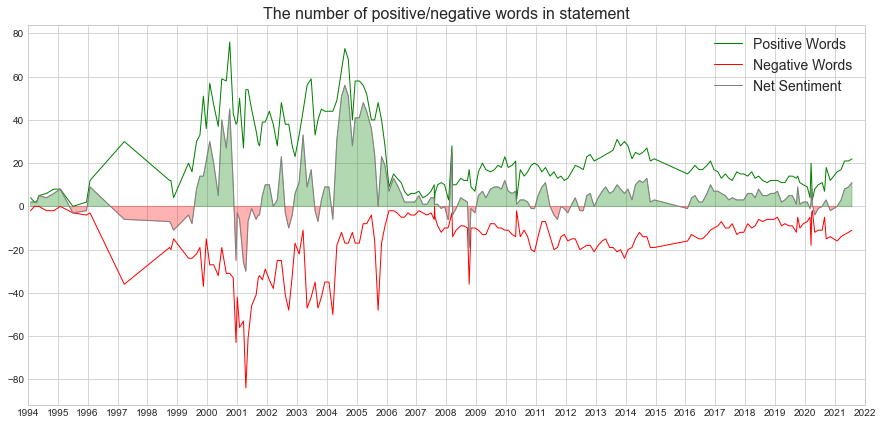

In [60]:
NetSentiment = Data['NPositiveWords'] - Data['NNegativeWords']

plt.figure(figsize=(15,7))
ax = plt.subplot()

plt.plot(Data.index, Data['NPositiveWords'], c='green', linewidth= 1.0)
plt.plot(Data.index, Data['NNegativeWords']*-1, c='red', linewidth=1.0)
plt.plot(Data.index, NetSentiment, c='grey', linewidth=1.0)

plt.title('The number of positive/negative words in statement', fontsize=16)
plt.legend(['Positive Words', 'Negative Words', 'Net Sentiment'], prop={'size': 14}, loc=1)

ax.fill_between(Data.index, NetSentiment, where=(NetSentiment > 0), color='green', alpha=0.3, interpolate=True)
ax.fill_between(Data.index, NetSentiment, where=(NetSentiment <= 0), color='red', alpha=0.3, interpolate=True)

import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

ax.grid(True)

plt.show()

Positive and negative word counts highly correlate... probably because of the total number of words varies. Take the positive - negative as Net Sentiment.

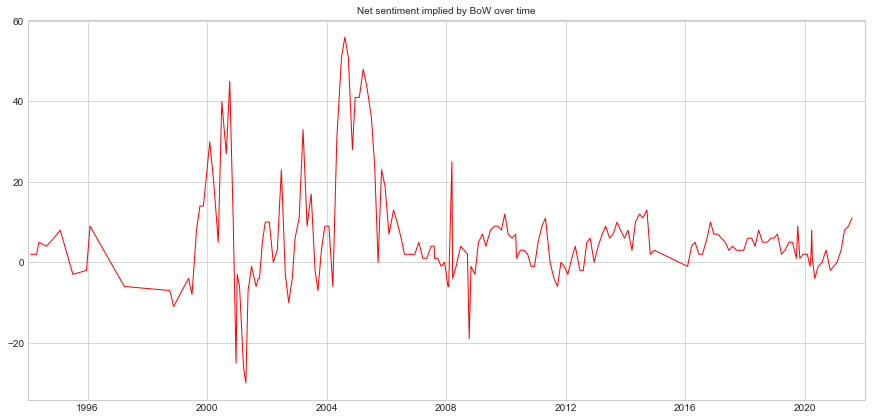

In [61]:
NetSentiment = Data['NPositiveWords'] - Data['NNegativeWords']

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(Data.index, NetSentiment, 
         c = 'red',
         linewidth= 1.0)

plt.title('Net sentiment implied by BoW over time',size = 'medium')

# format the ticks
# round to nearest years.
datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)


plt.show()

Plot derivative to see the changes in net sentiment

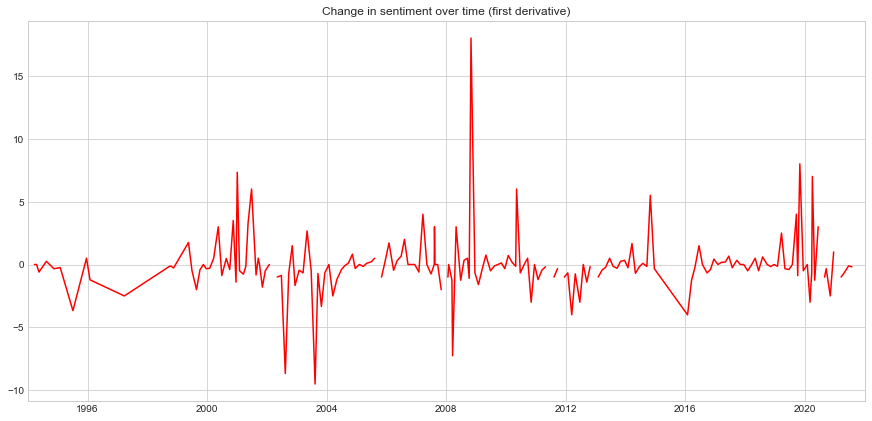

In [62]:
firstderivative = (NetSentiment.shift(1) - NetSentiment) / NetSentiment

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(Data.index, firstderivative, 
         c = 'red')

plt.title('Change in sentiment over time (first derivative)')

# format the ticks
# round to nearest years.
datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)


plt.show()

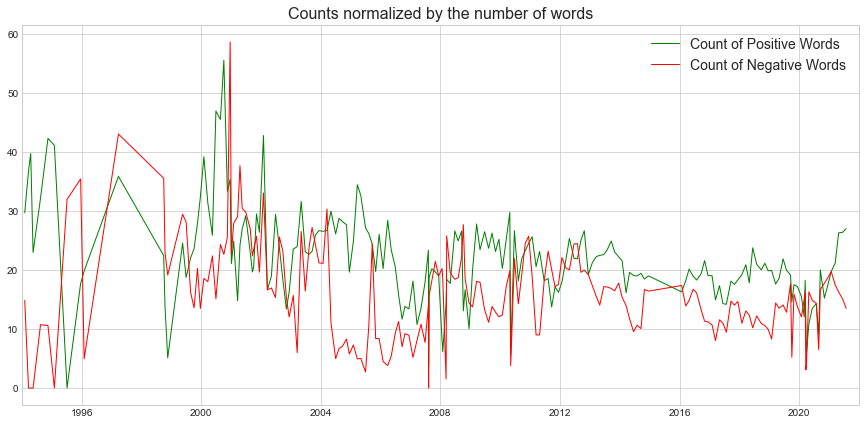

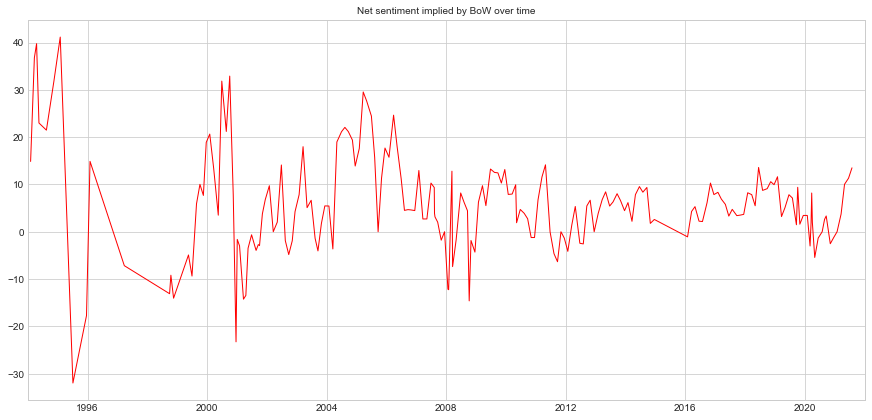

In [63]:
# Normalize data
NPositiveWordsNorm = Data['NPositiveWords'] / Data['wordcount'] * np.mean(Data['wordcount'])
NNegativeWordsNorm = Data['NNegativeWords'] / Data['wordcount'] * np.mean(Data['wordcount'])
NetSentimentNorm = (NPositiveWordsNorm - NNegativeWordsNorm)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(Data.index, NPositiveWordsNorm, c='green', linewidth= 1.0)
plt.plot(Data.index, NNegativeWordsNorm, c='red', linewidth=1.0)

plt.title('Counts normalized by the number of words', fontsize=16)
plt.legend(['Count of Positive Words', 'Count of Negative Words'],
           prop={'size': 14},
           loc = 1
           )

# format the ticks
# round to nearest years.
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

plt.show()


fig, ax = plt.subplots(figsize=(15,7))
ax.plot(Data.index, NetSentimentNorm, c='red', linewidth=1.0)

plt.title('Net sentiment implied by BoW over time',size = 'medium')

# format the ticks
# round to nearest years.
datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)


plt.show()

### Function for extracting the direction of the rate change (hike, keep, lower)

Gets Basis Points Move and End Rate Value for Fed Rate and Discount Rate as well as Preferred Fed Rate Move from Statement Text

In [64]:
import nltk.data
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def ExtractKeyValues(text):
    
    '''
    First, the text is tokenized in to sentences and the fed funds target rate sentence is extracted 
    Secondly, the decision whether the fed target rate was hiked, kept or lowered is retreived to RateHike variable
    Third, the target rate range is extracted and saved in TargetRange (The max is extracted as it conveys most info)
    '''
    
    Potentials = [] #For storing the potential decision sentences
        
    #Remove the \n and replace them with dots 
    text = text.replace('\\n','. ')
       
    #Split the text in to a list of sentences
    paragraph_sentence_list = tokenizer.tokenize(text)
    #print('paragraph_sentence_list: ', paragraph_sentence_list)
        
    #Finds the sentences with the decisions 
    for Sentence in paragraph_sentence_list:
        
        #print('Sentence: ', Sentence)
        #Make the text lower case
        Sentence = Sentence.lower()

        if 'federal funds ' in Sentence and  'target' in Sentence:
            
            #Check if it contains a number
            if bool(re.search(r'\d', Sentence)):
                
                Potentials.append(Sentence)
        
    Potentials = ''.join(Potentials)
    #print('Potentials: ', Potentials)

    
    #Look for decision words related to raising rates
    r = Potentials.find('rais')
    i = Potentials.find('increas')
    upscore = max([r,i])
    
    #Look for decision words related to keeping rates
    k = Potentials.find('keep')
    m = Potentials.find('maintain')
    r = Potentials.find('remain')
    c = Potentials.find('current')
    keepscore = max([r,k,m,c])
    
    #Look for decision words related to decreasing rates
    l = Potentials.find('lower')
    d = Potentials.find('decreas')
    lowerscore = max([l,d])
    
    Summary = {1:upscore,
              0: keepscore,
              -1:lowerscore
              }
        
    #take the key that was mentioned first in the text
    RateHike = max(Summary.keys(), key=(lambda x: Summary[x]))

    #For extracting the target range 
    def RangeReader(Nums):
        
        def FractionReader(Fraction):
            
            '''
            Converts the fraction to a float
            ''' 
            i = 0
            if '/' in Fraction:
                if ' ' in Fraction:
                    i, Fraction = Fraction.split(' ')
                if '-' in Fraction:
                    i, Fraction = Fraction.split('-')
                if '‑' in Fraction:
                    i, Fraction = Fraction.split('‑')
                N, D = Fraction.split('/')
                return float(i) + float(N) / float(D)
            
            else:
                return float(i)+float(Fraction)
        
        #Splits the range based on to or -
        Splitters = [' to ','-']
        
        for Splitter in Splitters:
            if Splitter in Nums:
                TargetRange = Nums.split(Splitter)
                return FractionReader(TargetRange[0]), FractionReader(TargetRange[1])
        
        #If there was no splitter in the range (no range)
        return FractionReader(Nums)
        
        
    #Find the percentage change and take the closest digits
    Rate = Potentials[ : Potentials.find('percent') -1 ]
    Rate = Rate[-16:]
    # print(Rate)
    if re.search("\d", Rate):
        Rate = Rate[ re.search("\d", Rate).start() : ]
        TargetRange = np.max(RangeReader(Rate))
    else:
        Rate = None
        TargetRange = None
      
    return RateHike, TargetRange

Appends decision, dummy and Moves and End Rate Values for Fed and Disc Rate also appends preferred fed rate Move while measuring the speed of the extraction

In [65]:
Data.tail()
#Data.drop(index=[pd.to_datetime("2020-03-03")], inplace=True)

,contents,speaker,text,Index,wordcount,NPositiveWords,NNegativeWords,sentiment,Poswords,Negwords
date,,,,,,,,,,
2021-01-27,"The Federal Reserve, the central bank of the U...",Jerome Powell,"The Federal Reserve, the central bank of the U...",194,596,16,16,0.000000,"[stable, stability, tremendous, most, progress...","[challenging, hardship, weakness, adversely, w..."
2021-03-17,"The Federal Reserve, the central bank of the U...",Jerome Powell,"The Federal Reserve, the central bank of the U...",195,590,17,14,0.508475,"[stable, stability, tremendous, up, most, prog...","[challenging, hardship, adversely, weak, below..."
2021-04-28,"The Federal Reserve, the central bank of the U...",Jerome Powell,"The Federal Reserve, the central bank of the U...",196,587,21,13,1.362862,"[stable, stability, tremendous, progress, stro...","[challenging, hardship, strong, adversely, wea..."
2021-06-16,"The Federal Reserve, the central bank of the U...",Jerome Powell,"The Federal Reserve, the central bank of the U...",197,585,21,12,1.538462,"[stable, stability, progress, progress, strong...","[challenging, strong, adversely, weak, crisis,..."
2021-07-28,"The Federal Reserve, the central bank of the U...",Jerome Powell,"The Federal Reserve, the central bank of the U...",198,599,22,11,1.836394,"[stable, stability, progress, strong, strength...","[challenging, strong, adversely, crisis, risks..."


Tried to take rate and decision from the statement text but it sometimes fails. Debugging takes time, so switch to use data instead of reading from text.

In [66]:
# import timeit

# start = timeit.timeit()

# #Append fed funds rates and decisions to dataframe
# Hikes = []
# TargetRate = []

# for i in range(len(Data)):
#     if Data.iloc[i,1] == True:
#         Hikes.append(np.nan)
#         TargetRate.append(np.nan)
#     else:
#         Hikes.append( ExtractKeyValues( Data.iloc[i,0] )[0] )
#         TargetRate.append( ExtractKeyValues( Data.iloc[i,0] )[1] )        
        
# Data['RateDecision'] = Hikes
# Data['FedFundRateEndValue'] = TargetRate

# end = timeit.timeit()

# print (str ( end - start ) + ' seconds elapsed for ' + str(i) + ' statements')

# Data.tail()

In [67]:
# FRB changed to range from 2008. So use Upper side from 2008.
filename_till08 = '../data/MarketData/Quandl/FRED_DFEDTAR.csv'
filename_from08u = '../data/MarketData/Quandl/FRED_DFEDTARU.csv'
filename_from08l = '../data/MarketData/Quandl/FRED_DFEDTARL.csv'

fedtar = pd.read_csv(filename_till08, names=['Date', 'Rate'], header=0)
fedtaru = pd.read_csv(filename_from08u, names=['Date', 'Rate'], header=0)
fedtarl = pd.read_csv(filename_from08l, names=['Date', 'Rate'], header=0)
fedrate_df = pd.concat([fedtar, fedtaru], axis=0)
fedrate_df.index = pd.to_datetime(fedrate_df.Date, format="%Y-%m-%d")
fedrate_df.drop(columns=['Date'], inplace=True)
fedrate_df['Rate'] = fedrate_df['Rate'].map(lambda x: np.float(x))
fedrate_df


,Rate
Date,
1982-09-27,10.25
1982-09-28,10.25
1982-09-29,10.25
1982-09-30,10.25
1982-10-01,10.00
...,...
2021-08-12,0.25
2021-08-13,0.25
2021-08-14,0.25


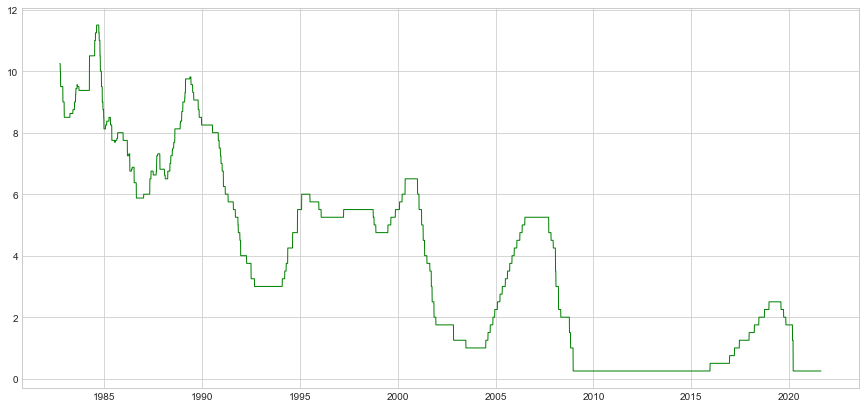

In [68]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(fedrate_df.index, fedrate_df['Rate'].values, c = 'green', linewidth= 1.0)
ax.grid(True)
plt.show()

In [69]:
Data['RateDecision'] = None
Data['Rate'] = None

for i in range(len(Data)):
    for j in range(len(fedrate_df)):
        if Data.index[i] == fedrate_df.index[j]:
            Data['Rate'][i] = float(fedrate_df['Rate'][j+1])
            if fedrate_df['Rate'][j-1] == fedrate_df['Rate'][j+1]:
                Data['RateDecision'][i] = 0
            elif fedrate_df['Rate'][j-1] < fedrate_df['Rate'][j+1]:
                Data['RateDecision'][i] = 1
            elif fedrate_df['Rate'][j-1] > fedrate_df['Rate'][j+1]:
                Data['RateDecision'][i] = -1

Data.head(10)

<ipython-input-69-08e74b406909>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['Rate'][i] = float(fedrate_df['Rate'][j+1])
<ipython-input-69-08e74b406909>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['RateDecision'][i] = 1
<ipython-input-69-08e74b406909>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['RateDecision'][i] = -1
<ipython-input-69-08e74b406909>:9: SettingWithCopyWarning: 
A value is trying to be set 

,contents,speaker,text,Index,wordcount,NPositiveWords,NNegativeWords,sentiment,Poswords,Negwords,RateDecision,Rate
date,,,,,,,,,,,,
1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,Chairman Alan Greenspan announced today that t...,0,99,4,2,2.020202,"[increase, increase, enhance, expansion]","[less, misunderstanding]",1,3.25
1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,Chairman Alan Greenspan announced today that t...,1,40,2,0,5.000000,"[increase, increase]",[],1,3.5
1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,Chairman Alan Greenspan announced today that t...,2,37,2,0,5.405405,"[increase, increase]",[],1,3.75
1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today ann...,Alan Greenspan,The Federal Reserve today announced two action...,3,160,5,0,3.125000,"[favorable, expansion, increase, effective, in...",[],1,4.25
1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced...,Alan Greenspan,The Federal Reserve announced today the follow...,4,137,6,2,2.919708,"[strength, expansion, high, sustainable, growt...","[against, least]",1,4.75
1994-11-15,\n\n[SECTION]\n\nThe Federal Reserve Board tod...,Alan Greenspan,The Federal Reserve Board today approved an in...,5,139,8,2,4.316547,"[increase, effective, increase, strength, high...","[against, persistent]",1,5.5
1995-02-01,\n\n[SECTION]\n\nFor immediate release\n\n[SEC...,Alan Greenspan,For immediate releaseThe Federal Reserve Board...,6,143,8,0,5.594406,"[increase, effective, increase, despite, growt...",[],1,6.0
1995-07-06,\n\n[SECTION]\n\nFor immediate release\n\n[SEC...,Alan Greenspan,For immediate releaseChairman Alan Greenspan a...,7,69,0,3,-4.347826,[],"[decrease, tightening, decline]",-1,5.75
1995-12-19,\n\n[SECTION]\n\nFor immediate release\n\n[SEC...,Alan Greenspan,For immediate releaseChairman Alan Greenspan a...,8,83,2,4,-2.409639,"[more, favorable]","[decrease, easing, easing, decline]",-1,5.5


In [77]:
def pickle_dump(df, filename='no-filename.pickle'):
    if filename:
        with open(filename, "wb") as output_file:
            pickle.dump(df, output_file)

### Plot the results and compare to the economical uncertainty / systemic risk periods

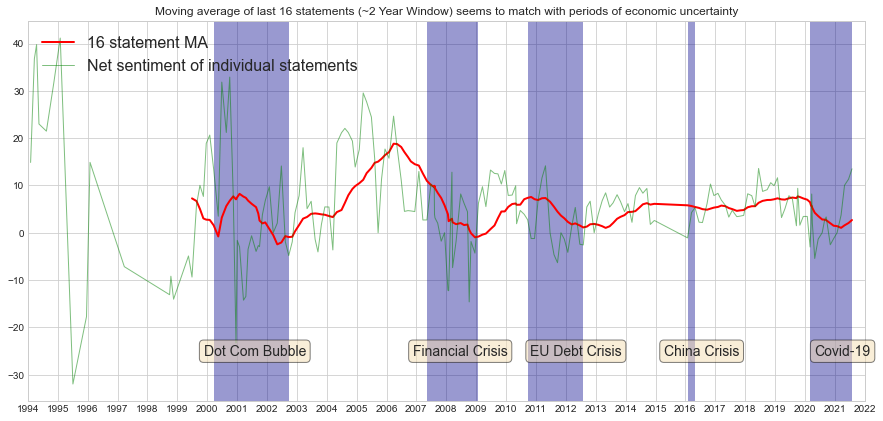

In [78]:
#Dot-com bubble
#https://en.wikipedia.org/wiki/Dot-com_bubble
DotCom = np.logical_and(Data.index > '2000-03', Data.index < '2002-10')

#Financial crisis of 2007–2008
#https://en.wikipedia.org/wiki/Financial_crisis_of_2007%E2%80%932008
FinCrisis = np.logical_and(Data.index > '2007-04', Data.index < '2009-03')

#European debt crisis
#https://en.wikipedia.org/wiki/European_debt_crisis
EuroDebt = np.logical_and(Data.index > '2010-09', Data.index < '2012-09')

#2015–16 Chinese stock market turbulence
#https://en.wikipedia.org/wiki/2015%E2%80%9316_Chinese_stock_market_turbulence
Asian = np.logical_and(Data.index > '2015-01', Data.index < '2016-06')

#2020- Covid-19 Pandemic
#https://en.wikipedia.org/wiki/COVID-19_pandemic
Covid = np.logical_and(Data.index > '2020-02', Data.index < '2021-12')

Recessions = np.logical_or.reduce((DotCom, FinCrisis, EuroDebt, Asian, Covid))

Window = 16
CompToMA = NetSentimentNorm.rolling(Window).mean()

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(Data.index, CompToMA, c = 'r', linewidth= 2)
ax.plot(Data.index, NetSentimentNorm, c = 'green', linewidth= 1, alpha = 0.5)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# round to nearest years.
datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

plt.title( str('Moving average of last ' + str(Window) + ' statements (~2 Year Window) seems to match with periods of economic uncertainty'))

ax.legend([str(str(Window) + ' statement MA'), 'Net sentiment of individual statements'],
           prop={'size': 16},
           loc = 2
          )

import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.9
ax.fill_between(Data.index, 0, 10, where = Recessions,
                facecolor='darkblue', alpha=0.4, transform=trans)

# Add text
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.21, 0.15, "Dot Com Bubble", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.46, 0.15, "Financial Crisis", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.60, 0.15, "EU Debt Crisis", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.76, 0.15, "China Crisis", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.94, 0.15, "Covid-19", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

plt.show()

In [79]:
# Speaker window
Greenspan = np.logical_and(Data.index > '1987-08-11', Data.index < '2006-01-31')
Bernanke = np.logical_and(Data.index > '2006-02-01', Data.index < '2014-01-31')
Yellen = np.logical_and(Data.index > '2014-02-03', Data.index < '2018-02-03')
Powell = np.logical_and(Data.index > '2018-02-05', Data.index < '2022-02-05')
Speaker = np.logical_or.reduce((Greenspan, Yellen))

# Moving Average
Window = 8
CompToMA = NetSentimentNorm.rolling(Window).mean()

# Plotting Data
fig, ax = plt.subplots(figsize=(15,7))
plt.title('Sentiment goes down before monetary easing', fontsize=16)

ax.scatter(Data.index, Data['Rate']*3, c = 'g')
ax.plot(Data.index, CompToMA, c = 'r', linewidth= 2.0)
ax.plot(Data.index, NetSentimentNorm,  c = 'green', linewidth= 1, alpha = 0.5)
ax.legend([str(str(Window) + ' statements moving average'),
           'Net sentiment of individual statements',
           'Fed Funds Rate'], prop={'size': 14}, loc = 1)

# Format X-axis
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# Set X-axis and Y-axis range
datemin = np.datetime64(Data.index[18], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)
ax.set_ylim(-10,30)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=12)

# Fill speaker
import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.9
ax.fill_between(Data.index, 0, 10, where = Speaker, facecolor='lightblue', alpha=0.5, transform=trans)

# Add text
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.13, 0.75, "Alan Greenspan", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.46, 0.75, "Ben Bernanke", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.73, 0.75, "Janet Yellen", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.88, 0.75, "Jerome Powell", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

# Add annotations
arrow_style = dict(facecolor='black', edgecolor='white', shrink=0.05)
ax.annotate('QE1', xy=('2008-11-25', 0), xytext=('2008-11-25', -4), size=12, ha='right', arrowprops=arrow_style)
ax.annotate('QE1+', xy=('2009-03-18', 0), xytext=('2009-03-18', -6), size=12, ha='center', arrowprops=arrow_style)
ax.annotate('QE2', xy=('2010-11-03', 0), xytext=('2010-11-03', -4), size=12, ha='center', arrowprops=arrow_style)
ax.annotate('QE2+', xy=('2011-09-21', 0), xytext=('2011-09-21', -4.5), size=12, ha='center', arrowprops=arrow_style)
ax.annotate('QE2+', xy=('2012-06-20', 0), xytext=('2012-06-20', -6.5), size=12, ha='right', arrowprops=arrow_style)
ax.annotate('QE3', xy=('2012-09-13', 0), xytext=('2012-09-13', -8), size=12, ha='center', arrowprops=arrow_style)
ax.annotate('Tapering', xy=('2013-12-18', 0), xytext=('2013-12-18', -8), size=12, ha='center', arrowprops=arrow_style)

plt.show()

ConversionError: Failed to convert value(s) to axis units: '2008-11-25'

<Figure size 1080x504 with 1 Axes>

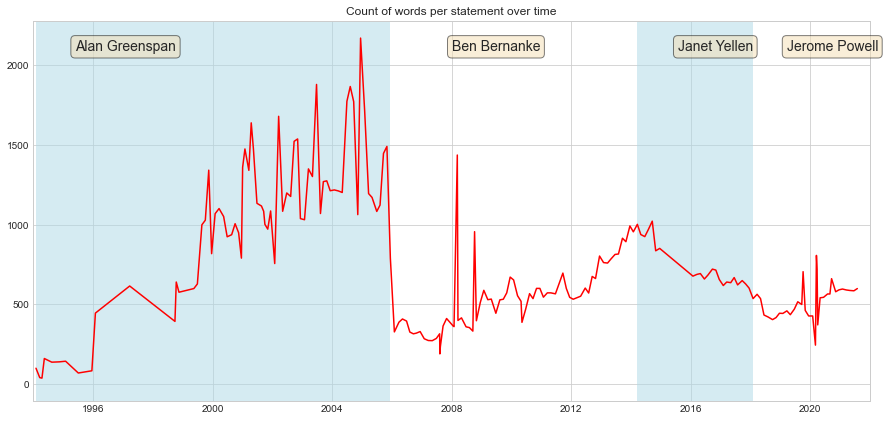

In [80]:
fig, ax = plt.subplots(figsize=(15,7))

Count = Data['wordcount']

ax.plot(Data.index, Count, 
         c = 'red',
         linewidth= 1.5)



plt.title('Count of words per statement over time')

import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# format the ticks
# round to nearest years.
datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.9
ax.fill_between(Data.index, 0, 10, where = Speaker,
                facecolor='lightblue', alpha=0.5, transform=trans)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, "Alan Greenspan", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.text(0.50, 0.95, "Ben Bernanke", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.text(0.77, 0.95, "Janet Yellen", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.text(0.90, 0.95, "Jerome Powell", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()